In [2]:
import os
from PIL import Image
import scipy.io
import h5py
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops
from skimage.transform import resize
import pandas as pd
from scipy.ndimage import sobel
import glob

In [3]:
mask_folder = './Dataset_BTP/A375_mask'
image_dimensions = {}

for image_name in os.listdir(mask_folder):
    if image_name.endswith('.png'):
        image_path = os.path.join(mask_folder, image_name)
        with Image.open(image_path) as img:
            width, height = img.size
            image_dimensions[image_name] = (width, height)

for image_name, dimensions in image_dimensions.items():
    print(f"{image_name}: {dimensions}")

A375_7.png: (2048, 1975)
A375_16.png: (2048, 1975)
A375_17.png: (2048, 1975)
A375_15.png: (2048, 1975)
A375_14.png: (2048, 1975)
A375_10.png: (2048, 1975)
A375_11.png: (2048, 1975)
A375_13.png: (2048, 1975)
A375_12.png: (2048, 1975)
A375_20.png: (2048, 1975)
A375_21.png: (2048, 1975)
A375_19.png: (2048, 1975)
A375_18.png: (2048, 1975)
A375_9.png: (2048, 1975)
A375_8.png: (2048, 1975)


In [4]:
opd_folder = './Dataset_BTP/A375_opd'
opd_dimensions = {}

for file_name in os.listdir(opd_folder):
    if file_name.endswith('.mat'):
        file_path = os.path.join(opd_folder, file_name)
        with h5py.File(file_path, 'r') as mat_file:
            for key in mat_file.keys():
                opd_dimensions[file_name] = mat_file[key].shape
                break

for file_name, dimensions in opd_dimensions.items():
    print(f"{file_name}: {dimensions}")

opd_a375_10.mat: (2048, 1975)
opd_a375_11.mat: (2048, 1975)
opd_a375_8.mat: (2048, 1975)
opd_a375_13.mat: (2048, 1975)
opd_a375_12.mat: (2048, 1975)
opd_a375_9.mat: (2048, 1975)
opd_a375_16.mat: (2048, 1975)
opd_a375_17.mat: (2048, 1975)
opd_a375_15.mat: (2048, 1975)
opd_a375_14.mat: (2048, 1975)
opd_a375_19.mat: (2048, 1975)
opd_a375_18.mat: (2048, 1975)
opd_a375_7.mat: (2048, 1975)
opd_a375_20.mat: (2048, 1975)
opd_a375_21.mat: (2048, 1975)


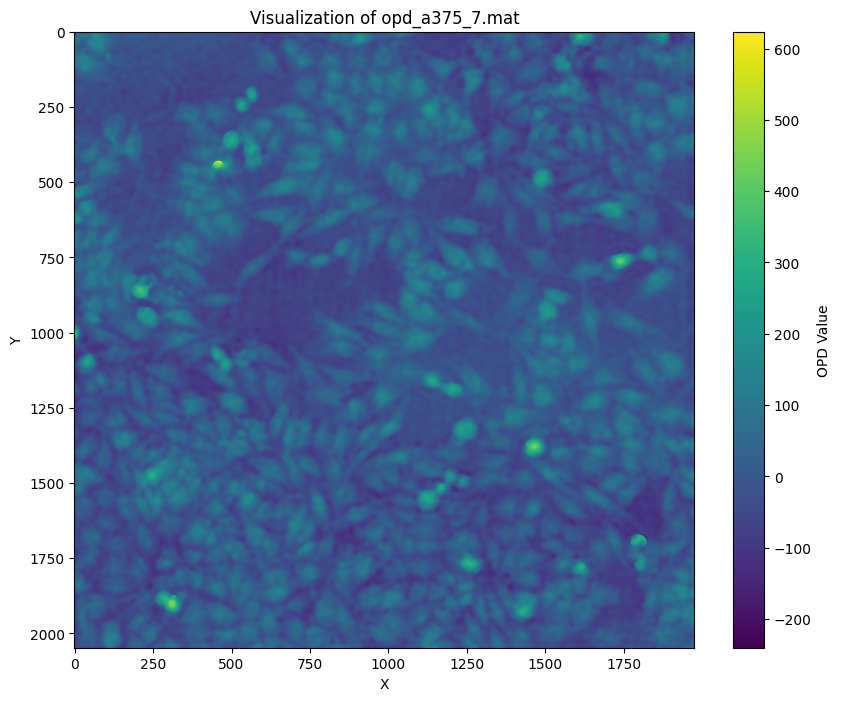

In [7]:
opd_file = './Dataset_BTP/A375_opd/opd_a375_7.mat'

with h5py.File(opd_file, 'r') as mat_file:
    for key in mat_file.keys():
        opd_matrix = mat_file[key][:]
        break

plt.figure(figsize=(10, 8))
plt.imshow(opd_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='OPD Value')
plt.title(f'Visualization of {os.path.basename(opd_file)}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

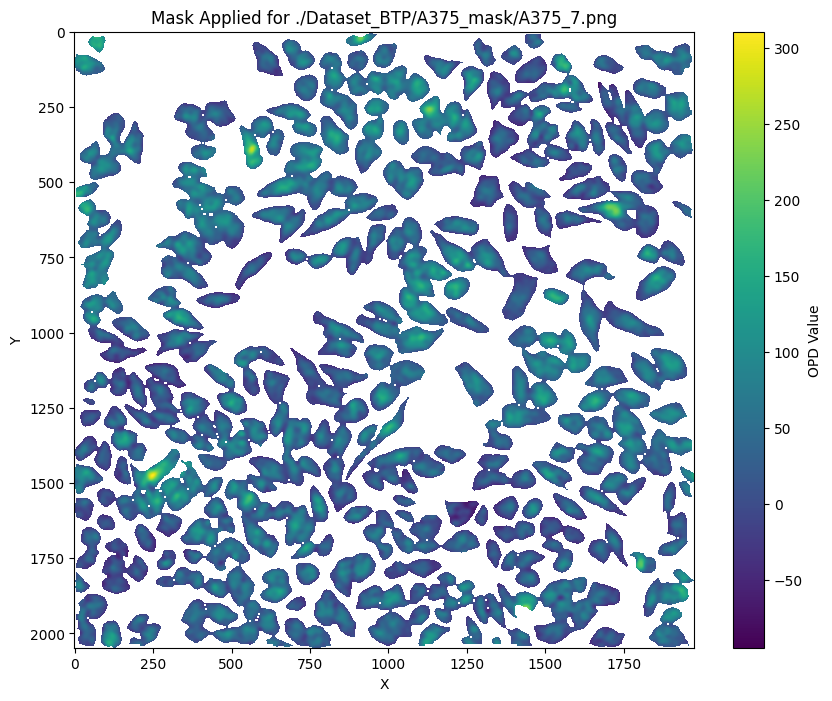

In [8]:
opd_file = './Dataset_BTP/A375_opd/opd_a375_7.mat'
mask_file = './Dataset_BTP/A375_mask/A375_7.png'

mask = np.array(Image.open(mask_file))
with h5py.File(opd_file, 'r') as mat_file:
    for key in mat_file.keys():
        opd_matrix = mat_file[key][:]
        break

masked_opd = np.where(mask.T > 0, opd_matrix, np.nan)
plt.figure(figsize=(10, 8))
plt.imshow(masked_opd, cmap='viridis', aspect='auto')
plt.colorbar(label='OPD Value')
plt.title(f'Mask Applied for {mask_file}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [ ]:
# DO FOR EVERY IMAGE

mask_file = './Dataset_BTP/A375_mask/A375_7.png'
opd_file = './Dataset_BTP/A375_opd/opd_a375_7.mat'
cell_opd_folder = './a375_cell_opd_data'

mask = np.array(Image.open(mask_file))

with h5py.File(opd_file, 'r') as mat_file:
    for key in mat_file.keys():
        opd_matrix = mat_file[key][:]
        break

masked_opd = np.where(mask.T > 0, opd_matrix, np.nan)
labeled_mask = label(mask.T)
regions = regionprops(labeled_mask)

for cell in regions:
    cell_id = cell.label
    cell_mask = (labeled_mask == cell_id)
    cell_opd = opd_matrix[cell_mask]
    cell_opd_matrix = np.full(opd_matrix.shape, np.nan)
    cell_opd_matrix[cell_mask] = cell_opd
    
    save_path = os.path.join(cell_opd_folder, f'opd_A375_7_cell_{cell_id}.mat')
    scipy.io.savemat(save_path, {'cell_opd': cell_opd_matrix})
    
    print(f"OPD matrix for cell {cell_id} saved as {save_path}")

print("OPD matrices for individual cells extracted and saved successfully.")

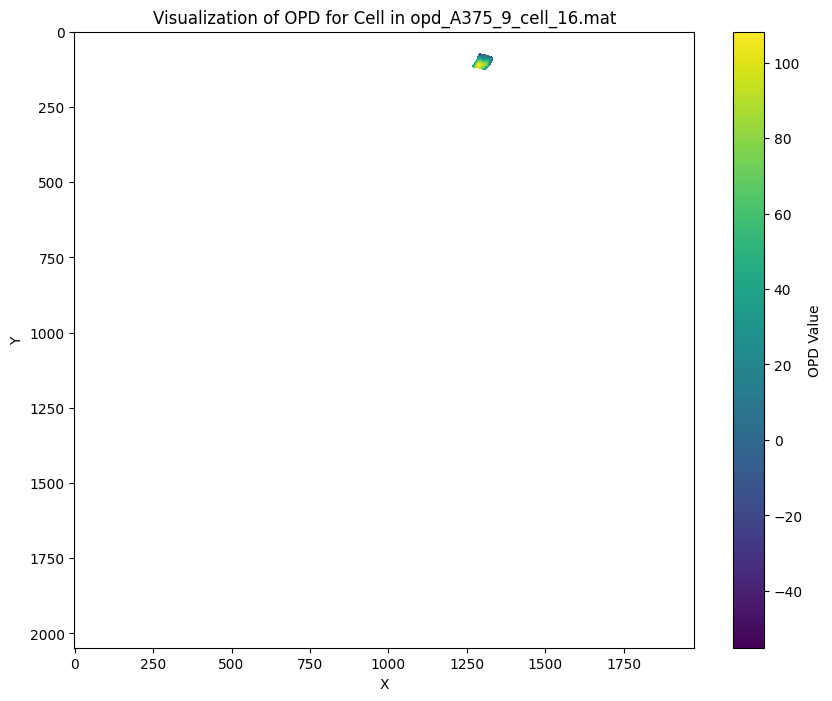

In [33]:
# TO CHECK IF THE CELL IS EXTRACTED PROPERLY

cell_opd_file = './a375_cell_opd_data/opd_A375_9_cell_16.mat'  
cell_data = scipy.io.loadmat(cell_opd_file)
cell_opd_matrix = cell_data['cell_opd']
plt.figure(figsize=(10, 8))
plt.imshow(cell_opd_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='OPD Value')
plt.title(f'Visualization of OPD for Cell in {os.path.basename(cell_opd_file)}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [35]:
cell_opd_folder = './a375_cell_opd_data'
output_mean_csv = './A375_CSV/cell_opd_mean.csv'
output_median_csv = './A375_CSV/cell_opd_median.csv'
mean_results = []
median_results = []

for file_name in os.listdir(cell_opd_folder):
    if file_name.endswith('.mat'):
        file_path = os.path.join(cell_opd_folder, file_name)
        opd_data = scipy.io.loadmat(file_path)['cell_opd']
        opd_data[opd_data < 0] = 0
        
        valid_opd_values = opd_data[np.isfinite(opd_data)]
        
        if valid_opd_values.size > 0:
            mean_opd = np.mean(valid_opd_values)
            median_opd = np.median(valid_opd_values)
        else:
            mean_opd = np.nan
            median_opd = np.nan
        
        parts = file_name.split('_')
        image_id = int(parts[2]) 
        cell_id = int(parts[-1].replace('.mat', '')) 

        mean_results.append({'Image_ID': image_id,'Cell_ID': cell_id,'Mean_OPD': mean_opd})

        median_results.append({'Image_ID': image_id,'Cell_ID': cell_id,'Median_OPD': median_opd})

df_mean = pd.DataFrame(mean_results)
df_median = pd.DataFrame(median_results)

df_mean.sort_values(by=['Image_ID', 'Cell_ID'], inplace=True)
df_median.sort_values(by=['Image_ID', 'Cell_ID'], inplace=True)

df_mean.to_csv(output_mean_csv, index=False)
df_median.to_csv(output_median_csv, index=False)


In [39]:
cell_opd_folder = './a375_cell_opd_data'
output_csv = './A375_CSV/cell_opd_dry_mass.csv'
mean_opd_csv = './A375_CSV/cell_opd_mean.csv'

refractive_increment = 0.2
mean_opd_df = pd.read_csv(mean_opd_csv)

mean_opd_dict = {(row['Image_ID'], row['Cell_ID']): row['Mean_OPD'] for _, row in mean_opd_df.iterrows()}
results_dry_mass = []

for opd_file in os.listdir(cell_opd_folder):
    if opd_file.endswith('.mat'):
        base_name = opd_file[:-4]
        parts = base_name.split('_')
        image_id = int(parts[2])
        cell_id = int(parts[4])
        mean_opd = mean_opd_dict.get((image_id, cell_id), np.nan)
        
        opd_path = os.path.join(cell_opd_folder, opd_file)
        mat_data = scipy.io.loadmat(opd_path)
        cell_opd_matrix = mat_data['cell_opd']
        cell_area = np.sum(~np.isnan(cell_opd_matrix))
        
        dry_mass = (cell_area * mean_opd) / refractive_increment
        results_dry_mass.append([image_id, cell_id, dry_mass])

df = pd.DataFrame(results_dry_mass, columns=['Image_ID', 'Cell_ID', 'Dry_Mass'])
df_sorted = df.sort_values(by=['Image_ID', 'Cell_ID'])
df_sorted.to_csv(output_csv, index=False)


In [42]:
cell_opd_folder = './a375_cell_opd_data'
output_csv = './A375_CSV/cell_opd_density.csv'
mean_opd_csv = './A375_CSV/cell_opd_mean.csv'

refractive_increment = 0.2
mean_opd_df = pd.read_csv(mean_opd_csv)

mean_opd_dict = {(row['Image_ID'], row['Cell_ID']): row['Mean_OPD'] for _, row in mean_opd_df.iterrows()}
results_density = []

for opd_file in os.listdir(cell_opd_folder):
    if opd_file.endswith('.mat'):
        base_name = opd_file[:-4]
        parts = base_name.split('_')
        image_id = int(parts[2])
        cell_id = int(parts[4])
        mean_opd = mean_opd_dict.get((image_id, cell_id), np.nan)
        
        density = (mean_opd) / refractive_increment
        results_density.append([image_id, cell_id, density])

df = pd.DataFrame(results_density, columns=['Image_ID', 'Cell_ID', 'Density'])
df_sorted = df.sort_values(by=['Image_ID', 'Cell_ID'])
df_sorted.to_csv(output_csv, index=False)


In [43]:
cell_opd_folder = './a375_cell_opd_data'
output_csv = './A375_CSV/cell_opd_phase_volume.csv'
dry_mass_opd_csv = './A375_CSV/cell_opd_dry_mass.csv'

refractive_increment = 0.2
dry_mass_opd_df = pd.read_csv(dry_mass_opd_csv)

dry_mass_opd_dict = {(row['Image_ID'], row['Cell_ID']): row['Dry_Mass'] for _, row in dry_mass_opd_df.iterrows()}
results_phase_volume = []

for opd_file in os.listdir(cell_opd_folder):
    if opd_file.endswith('.mat'):
        base_name = opd_file[:-4]
        parts = base_name.split('_')
        image_id = int(parts[2])
        cell_id = int(parts[4])
        dry_mass_opd = dry_mass_opd_dict.get((image_id, cell_id), np.nan)
        
        phase_volume = (dry_mass_opd) * refractive_increment
        results_phase_volume.append([image_id, cell_id, phase_volume])

df = pd.DataFrame(results_phase_volume, columns=['Image_ID', 'Cell_ID', 'Phase Volume'])
df_sorted = df.sort_values(by=['Image_ID', 'Cell_ID'])
df_sorted.to_csv(output_csv, index=False)


In [44]:
cell_opd_folder = './a375_cell_opd_data'
output_surface_area_csv = './A375_CSV/cell_phase_surface_area.csv'

surface_area_results = []
for opd_file in os.listdir(cell_opd_folder):
    if opd_file.endswith('.mat'):
        base_name = opd_file[:-4]
        parts = base_name.split('_')
        image_id = int(parts[2])
        cell_id = int(parts[4])
        
        opd_path = os.path.join(cell_opd_folder, opd_file)
        mat_data = scipy.io.loadmat(opd_path)
        cell_opd_matrix = mat_data['cell_opd']
        
        opd_dx = sobel(cell_opd_matrix, axis=1)
        opd_dy = sobel(cell_opd_matrix, axis=0)
        surface_area_element = np.sqrt(1 + opd_dx**2 + opd_dy**2)
        surface_area = np.nansum(surface_area_element)
        
        surface_area_results.append([image_id, cell_id, surface_area])


df_surface_area = pd.DataFrame(surface_area_results, columns=['Image_ID', 'Cell_ID', 'Phase_Surface_Area'])
df_surface_area_sorted = df_surface_area.sort_values(by=['Image_ID', 'Cell_ID'])
df_surface_area_sorted.to_csv(output_surface_area_csv, index=False)


In [45]:
surface_area_csv = './A375_CSV/cell_phase_surface_area.csv'
volume_csv = './A375_CSV/cell_opd_phase_volume.csv'
output_csv = './A375_CSV/cell_phase_surface_area_to_volume_ratio.csv'
surface_area_df = pd.read_csv(surface_area_csv)
volume_df = pd.read_csv(volume_csv)

merged_df = pd.merge(surface_area_df, volume_df, on=['Image_ID', 'Cell_ID'])
merged_df['Phase_Surface_Area_to_Volume_Ratio'] = merged_df['Phase_Surface_Area'] / merged_df['Phase Volume']
result_df = merged_df[['Image_ID', 'Cell_ID', 'Phase_Surface_Area_to_Volume_Ratio']]
result_df = result_df.sort_values(by=['Image_ID', 'Cell_ID'])
result_df.to_csv(output_csv, index=False)


In [46]:
surface_area_csv = './A375_CSV/cell_phase_surface_area.csv'
mass_csv = './A375_CSV/cell_opd_dry_mass.csv'
output_csv = './A375_CSV/cell_phase_surface_area_to_dry_mass_ratio.csv'
surface_area_df = pd.read_csv(surface_area_csv)
mass_df = pd.read_csv(mass_csv)

merged_df = pd.merge(surface_area_df, mass_df, on=['Image_ID', 'Cell_ID'])
merged_df['Phase_Surface_Area_to_Dry_Mass_Ratio'] = merged_df['Phase_Surface_Area'] / merged_df['Dry_Mass']
result_df = merged_df[['Image_ID', 'Cell_ID', 'Phase_Surface_Area_to_Dry_Mass_Ratio']]
result_df = result_df.sort_values(by=['Image_ID', 'Cell_ID'])
result_df.to_csv(output_csv, index=False)


In [47]:
cell_opd_folder = './a375_cell_opd_data'
volume_csv = './A375_CSV/cell_opd_phase_volume.csv'
output_csv = './A375_CSV/cell_projected_area_to_volume.csv'

volume_df = pd.read_csv(volume_csv)
volume_dict = {(row['Image_ID'], row['Cell_ID']): row['Phase Volume'] for _, row in volume_df.iterrows()}

projected_area_to_volume_results = []
for opd_file in os.listdir(cell_opd_folder):
    if opd_file.endswith('.mat'):
        base_name = opd_file[:-4]
        parts = base_name.split('_')
        image_id = int(parts[2])
        cell_id = int(parts[4])
        
        volume = volume_dict.get((image_id, cell_id), np.nan)
        
        opd_path = os.path.join(cell_opd_folder, opd_file)
        mat_data = scipy.io.loadmat(opd_path)
        cell_opd_matrix = mat_data['cell_opd']
        cell_area = np.sum(~np.isnan(cell_opd_matrix))
        # print(cell_area)

        if volume != 0:
            projected_area_to_volume = cell_area / volume
        else:
            projected_area_to_volume = np.nan
        
        projected_area_to_volume_results.append([image_id, cell_id, projected_area_to_volume])

df_projectedarea = pd.DataFrame(projected_area_to_volume_results, columns=['Image_ID', 'Cell_ID', 'Projected_Area_To_Volume'])
df_projectedarea_sorted = df_projectedarea.sort_values(by=['Image_ID', 'Cell_ID'])

df_projectedarea_sorted.to_csv(output_csv, index=False)


In [48]:
surface_area_csv = './A375_CSV/cell_phase_surface_area.csv'
volume_csv = './A375_CSV/cell_opd_phase_volume.csv'
output_csv = './A375_CSV/cell_opd_phase_sphericity_index.csv'

df_surface_area = pd.read_csv(surface_area_csv)
df_volume = pd.read_csv(volume_csv)

df_merged = pd.merge(df_surface_area, df_volume, on=['Image_ID', 'Cell_ID'])
df_merged['Phase_Sphericity_Index'] = (np.pi**(1/3) * (6 * df_merged['Phase Volume'])**(2/3)) / df_merged['Phase_Surface_Area']
df_merged[['Image_ID', 'Cell_ID', 'Phase_Sphericity_Index']].to_csv(output_csv, index=False)


In [49]:
cell_opd_folder = './a375_cell_opd_data'
output_csv = './A375_CSV/cell_opd_phase_variance.csv'

variance_results = []

for opd_file in os.listdir(cell_opd_folder):
    if opd_file.endswith('.mat'):
        file_path = os.path.join(cell_opd_folder, opd_file)

        mat_data = scipy.io.loadmat(file_path)
        cell_opd_matrix = mat_data['cell_opd']
        
        valid_opd_values = cell_opd_matrix[np.isfinite(cell_opd_matrix)].flatten()
        K = len(valid_opd_values)

        if K > 1:
            mean_opd = np.mean(valid_opd_values)
            phase_variance = np.var(valid_opd_values, ddof=1)
        else:
            mean_opd = np.nan
            phase_variance = np.nan
        
        parts = opd_file.split('_')
        image_id = int(parts[2]) 
        cell_id = int(parts[-1].replace('.mat', '')) 

        variance_results.append({
            'Image_ID': image_id,
            'Cell_ID': cell_id,
            'Phase_Variance': phase_variance
        })
df_variance = pd.DataFrame(variance_results)
df_variance_sorted = df_variance.sort_values(by=['Image_ID', 'Cell_ID'])
df_variance_sorted.to_csv(output_csv, index=False)


In [50]:
cell_opd_folder = './a375_cell_opd_data'
output_csv = './A375_CSV/cell_opd_phase_kurtosis.csv'

results_kurtosis = []

for opd_file in os.listdir(cell_opd_folder):
    if opd_file.endswith('.mat'):
        base_name = opd_file[:-4]
        parts = base_name.split('_')
        image_id = int(parts[2])
        cell_id = int(parts[4])
        
        opd_path = os.path.join(cell_opd_folder, opd_file)
        mat_data = scipy.io.loadmat(opd_path)
        cell_opd_matrix = mat_data['cell_opd']
        
        valid_opd_values = cell_opd_matrix[np.isfinite(cell_opd_matrix)]
        if valid_opd_values.size > 0:
            mean_opd = np.mean(valid_opd_values)
            variance_opd = np.var(valid_opd_values, ddof=0)
            fourth_moment = np.mean((valid_opd_values - mean_opd)**4)
            kurtosis = fourth_moment / (variance_opd**2)
        else:
            kurtosis = np.nan
        
        results_kurtosis.append([image_id, cell_id, kurtosis])

df = pd.DataFrame(results_kurtosis, columns=['Image_ID', 'Cell_ID', 'Phase_Kurtosis'])
df_sorted = df.sort_values(by=['Image_ID', 'Cell_ID'])
df_sorted.to_csv(output_csv, index=False)


/var/folders/ms/jcbjc8jx1414fy57pjk6fh780000gn/T/ipykernel_75483/1552133059.py:22: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = fourth_moment / (variance_opd**2)


In [51]:
cell_opd_folder = './a375_cell_opd_data'
output_csv = './A375_CSV/cell_opd_phase_skewness.csv'

results_skewness = []

for opd_file in os.listdir(cell_opd_folder):
    if opd_file.endswith('.mat'):
        base_name = opd_file[:-4]
        parts = base_name.split('_')
        image_id = int(parts[2])
        cell_id = int(parts[4])
        
        opd_path = os.path.join(cell_opd_folder, opd_file)
        mat_data = scipy.io.loadmat(opd_path)
        cell_opd_matrix = mat_data['cell_opd']
        
        valid_opd_values = cell_opd_matrix[np.isfinite(cell_opd_matrix)]
        if valid_opd_values.size > 0:
            mean_opd = np.mean(valid_opd_values)
            variance_opd = np.var(valid_opd_values, ddof=0)
            std_dev_opd = np.sqrt(variance_opd)
            skewness = np.mean((valid_opd_values - mean_opd)**3) / (std_dev_opd**3)
        else:
            skewness = np.nan
        
        results_skewness.append([image_id, cell_id, skewness])

df = pd.DataFrame(results_skewness, columns=['Image_ID', 'Cell_ID', 'Phase_Skewness'])
df_sorted = df.sort_values(by=['Image_ID', 'Cell_ID'])
df_sorted.to_csv(output_csv, index=False)

/var/folders/ms/jcbjc8jx1414fy57pjk6fh780000gn/T/ipykernel_75483/3306830337.py:22: RuntimeWarning: invalid value encountered in scalar divide
  skewness = np.mean((valid_opd_values - mean_opd)**3) / (std_dev_opd**3)


In [52]:
cell_opd_folder = './a375_cell_opd_data'
output_csv = './A375_CSV/cell_opd_energy.csv'

results_energy = []

for opd_file in os.listdir(cell_opd_folder):
    if opd_file.endswith('.mat'):
        base_name = opd_file[:-4]
        parts = base_name.split('_')
        image_id = int(parts[2])
        cell_id = int(parts[4])
        
        opd_path = os.path.join(cell_opd_folder, opd_file)
        mat_data = scipy.io.loadmat(opd_path)
        cell_opd_matrix = mat_data['cell_opd']
        
        valid_opd_values = cell_opd_matrix[np.isfinite(cell_opd_matrix)]
        if valid_opd_values.size > 0:
            mean_opd = np.mean(valid_opd_values)
            energy = np.sum((valid_opd_values - mean_opd)**2)
        else:
            energy = np.nan
        
        results_energy.append([image_id, cell_id, energy])

df = pd.DataFrame(results_energy, columns=['Image_ID', 'Cell_ID', 'Energy'])
df_sorted = df.sort_values(by=['Image_ID', 'Cell_ID'])
df_sorted.to_csv(output_csv, index=False)


In [53]:

csv_folder = './A375_CSV'
output_csv = './A375_Features.csv'
csv_files = glob.glob(f"{csv_folder}/*.csv")
merged_df = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on=['Image_ID', 'Cell_ID'], how='outer')
merged_df.to_csv(output_csv, index=False)
print(f"Merged CSV saved to {output_csv}")


Merged CSV saved to ./A375_Features.csv
